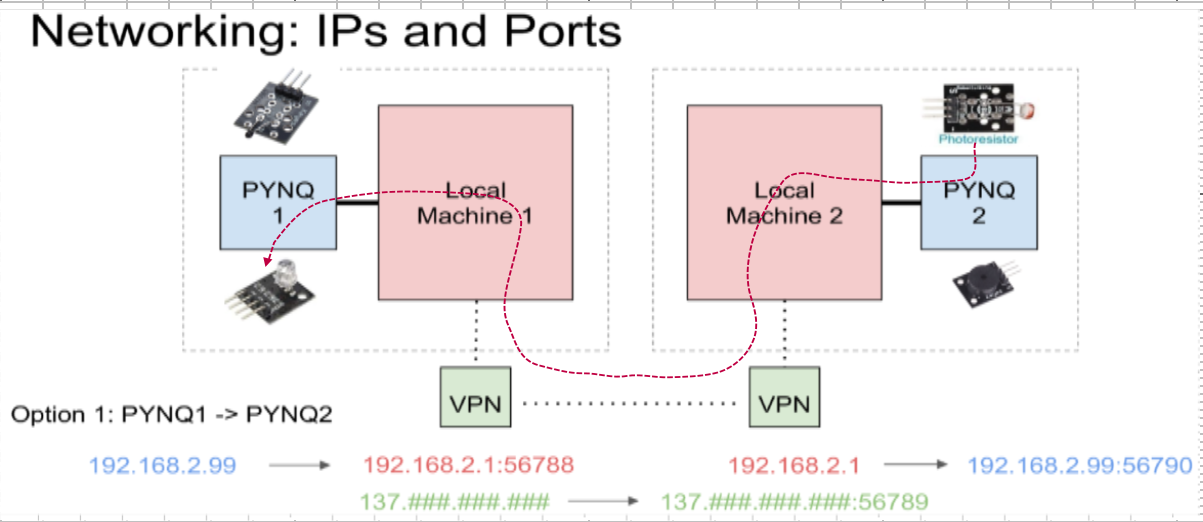

# PYNQ 1 as server, LED

In [1]:
# Photoresistor to LED (Red dash line)
import multiprocessing
import threading
import time
import socket
import os
import random
import asyncio

from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")
btns = base.btns_gpio

In [2]:
%%microblaze base.PMODB

#include "gpio.h"
#include "pyprintf.h"

//Function to turn on/off a selected pin of PMODB
void write_gpio(unsigned int pin, unsigned int val){
    if (val > 1){
        pyprintf("pin value must be 0 or 1");
    }
    gpio pin_out = gpio_open(pin);
    gpio_set_direction(pin_out, GPIO_OUT);
    gpio_write(pin_out, val);
}

//Function to read the value of a selected pin of PMODB
unsigned int read_gpio(unsigned int pin){
    gpio pin_in = gpio_open(pin);
    gpio_set_direction(pin_in, GPIO_IN);
    return gpio_read(pin_in);
}

In [3]:
def setAllOff():
    write_gpio(3, 0)
    write_gpio(2, 0)
    write_gpio(1, 0)

#asyncio is often a perfect fit for IO-bound and high-level structured network code 

cond = True
#start = 0
lit_int = 3000
thresh_L, thresh_M, thresh_H = 1000, 2000, 3000

async def runPWMLED(f, dc):
    T = 1/f
    
    global cond, lit_int #start
    while cond:
        #print("running...")
        if lit_int <= thresh_L:      # blinking Red led as initial condition
            write_gpio(3, 1)
            await asyncio.sleep(T * dc)
            write_gpio(3, 0)
            await asyncio.sleep(T * (1-dc))
    
        elif (lit_int > thresh_L and lit_int <= thresh_H):      # blinking green led
            write_gpio(2, 1)
            await asyncio.sleep(T * dc)
            write_gpio(2, 0)
            await asyncio.sleep(T * (1-dc))
          
        elif lit_int > thresh_H:      # blinking blue led
            write_gpio(1, 1)
            await asyncio.sleep(T * dc)
            write_gpio(1, 0)
            await asyncio.sleep(T * (1-dc))
            
async def get_btns(_loop):
    global cond, start
    while cond:
        await asyncio.sleep(0.01)
  
        if btns.read() == 8: #stop blinking
            cond = False
            await asyncio.sleep(0.3)
            print("pressing BTN3, stop blinking")
            _loop.stop()

In [4]:
async def unit_test():  # test the switch using random generation of integer
    global cond, lit_int#, lit_int
    while cond:
        await asyncio.sleep(5)
        lit_int = random.randint(0,4095)
        print('lit_int = ', lit_int)

In [5]:
setAllOff()

In [6]:
def runLEDOperation(f, dc, test):
    loop = asyncio.new_event_loop()    # Create and return a new event loop object.
    loop.create_task(runPWMLED(f, dc)) # blink the LED’s  in intervals of 1 second (i.e. 1 second on, 1 second off)
    loop.create_task(get_btns(loop))
    
    if (test == True):
        loop.create_task(unit_test())
    
    loop.run_forever()
    loop.close()

In [7]:
# unit test
#f, dc, test = 1/2, 0.2, True
#runLEDOperation(f, dc, test)

In [8]:
procs = []      # process

def runServer(i_cpu, port):
    global cond, lit_int
    """
    see async def operation(rt, f) above
    cond    condition for loop
    lit_int intensity of photoresistor
    """
    print("Server running on CPU_{} at port {}...\n".format(i_cpu, port))
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    # 1. Bind the socket to the pynq board 
    #<CLIENT-IP>, 0.0.0.0' for any clients, at port <LISTENING-PORT>
    sock.bind(('0.0.0.0', port))
    
    # 2. Accept connections
    # Enable a server to accept connections
    sock.listen()
    
    conn, addr = sock.accept()
    print('Connected by', addr)
    
    if addr:
        f, dc, test = 1/2, 0.2, False
        #t = threading.Thread(target=runOperation, args=(f, dc, ))
        t = threading.Thread(target=runLEDOperation, args=(f, dc, test, ))
        
        tName = t.getName()
    
    t.start()
    #print('t.start()')
    
    condLoop = True
    while condLoop:
        data = conn.recv(1024)
        choice = data.decode('ASCII')
        if not data: break
        print('Received ', str(choice))    
        lit_int = int(choice)
        print('lit_int ', lit_int)
        #print(type(lit_int))
        #print(lit_int <= thresh_L)
        #print((lit_int > thresh_L and start <= thresh_H))
        #print(lit_int > thresh_H)
        
    
    t.join()
    print("{} joined.".format(tName))
    sock.close()
    print('Sock closed.')  

In [19]:
# creating process, the first arg defines which CPU to run the 'target' on
i_cpu, port = 0, 8883 #'PYNQ'
pS = multiprocessing.Process(target=runServer, args=(i_cpu, port,))

# Execute the command (a string) in a subshell,  
# taskset is an os command to pin the process to a specific CPU
os.system("taskset -p -c {} {}".format(i_cpu, pS.pid))

pS.start()          # start the process
procs.append(pS)

Server running on CPU_0 at port 8883...

Connected by ('192.168.2.1', 47310)
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  0

lit_int  0
Received  1376

lit_int  1376
Received  1376

lit_int  1376
Received  1376

lit_int  1376
Received  1376

lit_int  1376
Received  1376

lit_int  1376
Received  1376

lit_int  1376
Received  1376

lit_int  1376
Received  1376

lit_int  1376
Received  1376

lit_int  1376
Received  1376

lit_int  1376
Received  1376

lit_int


lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  

Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  


lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  1060
Received  1060

lit_int  

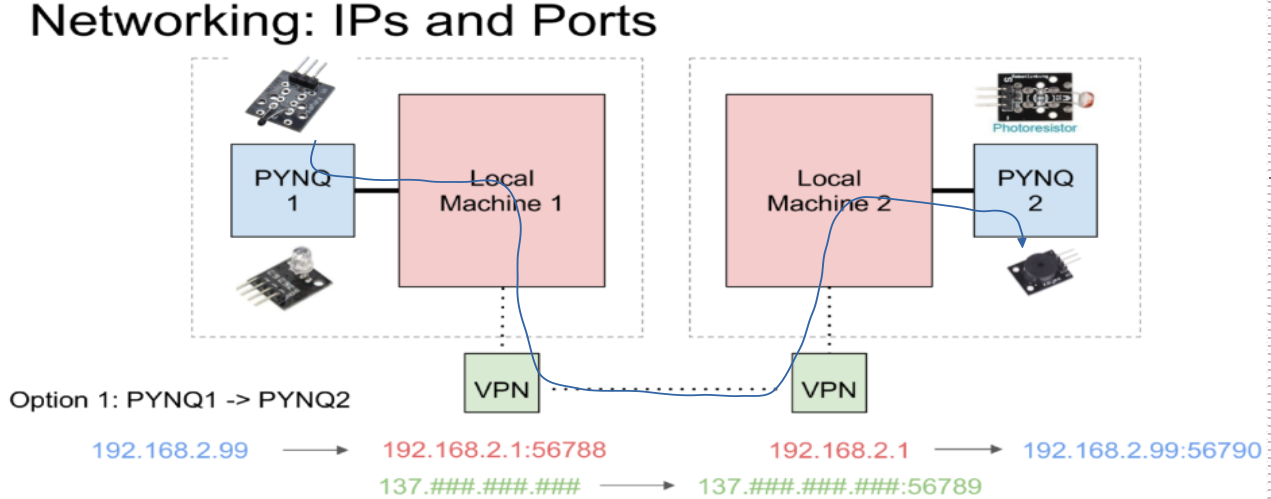

# PYNQ1 as client, analogy temp

In [10]:
from pynq.lib import Pmod_ADC    # Pmod_ADC library

In [11]:
adc = Pmod_ADC(base.PMODA)

reading = adc.read_raw(ch1=0, ch2=0, ch3=1)[0] # Get the raw value from the Pmod ADC.
print(reading)

4095


In [20]:
def runClient(i_cpu, ip, port, test):
    global cond, start
    
    print("Client running on CPU_{} connecting server @ ip {}:port {}...\n".format(i_cpu, ip, port))
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    # 1: Connect the socket (sock) to the <SERVER-IP> and choosen port <LISTENING-PORT>
    sock.connect((str(ip), port))
    

    # 2: Send messages
    t = threading.Thread(target=runBottonLoop_2, args=(test,))
    name = t.getName()
    t.start()
    
    condLoop = True
    start = 0
    while condLoop:
        time.sleep(0.1)
        bMsg = (str(start)+'\n').encode('ASCII')
        sock.send(bMsg)
        time.sleep(0.1)
        """
        if start == 0:
            time.sleep(0.3)
        if start == 1:
            time.sleep(0.3)
              
            bMsg = (str(start)+'\n').encode('ASCII')
            sock.send(bMsg)
            #print('Here', str(start)) 
            start = 0
            
        if start == 2:
            time.sleep(0.3)
            
            bMsg = (str(start)+'\n').encode('ASCII')
            sock.send(bMsg)
            #print('Here', str(start))
            start = 0

            
        if start == 4:    
            time.sleep(0.3)
            
            bMsg = (str(start)+'\n').encode('ASCII')
            sock.send(bMsg)
            #print('Here', str(start))
            start = 0          
            condLoop = False
        """
        
    print('{} joined'.format(name))
    t.join()
    
    # 3: Close the socket
    sock.close()

    
async def get_btns_2(_loop):
    global cond, start
    while cond:
        await asyncio.sleep(0.01)
        #print('cond')
        """
        if btns.read() == 1: # the first button on the very right
            start = 1
            await asyncio.sleep(0.3)
            print("pressing BTN0")
                    
        elif btns.read() == 2: # buzzer
            start = 2
            await asyncio.sleep(0.3)
            print("pressing BTN1")
       """
        if btns.read() == 8: # blinking blue led
            
            cond = False
            await asyncio.sleep(0.3)
            print('\n')
            print("pressing BTN3, stop the client")
            _loop.stop()

            
async def getAnalogTemp(test):
    global cond, start
    while cond:
        await asyncio.sleep(5)
        if test == False:
            reading = adc.read_raw(ch1=0, ch2=0, ch3=1)[0]  # This is where t replace with the reading from sensor
        reading = random.randint(0,4095)
        start = int(reading)
        print("start = ", start)
            
def runBottonLoop_2(test):
    loop = asyncio.new_event_loop()    # Create and return a new event loop object.
    loop.create_task(getAnalogTemp(test))
    loop.create_task(get_btns_2(loop))
    loop.run_forever()
    loop.close()   
    print("Exit loop...")

In [21]:
# creating process, the first arg defines which CPU to run the 'target' on
i_cpu, ip, port, test = 1, '192.168.2.1', 50005, True
pC = multiprocessing.Process(target=runClient, args=(i_cpu, ip, port, test, ))

# Execute the command (a string) in a subshell,  
# taskset is an os command to pin the process to a specific CPU
os.system("taskset -p -c {} {}".format(i_cpu, pC.pid))

pC.start()          # start the process
procs.append(pC)
pCName = pC.name    # get process1 name

Client running on CPU_1 connecting server @ ip 192.168.2.1:port 50005...

start =  1376
start =  76
start =  3888
start =  3991
start =  301
start =  210
start =  1060


pressing BTN3, stop the client
Exit loop...


In [ ]:
for pO in procs:
    name = pO.name
    pO.join()
    print("{} joined.".format(name))